In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
import os
import sys

sys.path.append(os.path.abspath('..'))
warnings.simplefilter(action='ignore', category=FutureWarning)

# Caricamento del dataset
filename = '../data/temp/01_training_data_segmented.csv'
try:
    df_segmented = pd.read_csv(filename)
    print("Dataset caricato correttamente.")
except FileNotFoundError:
    print(f"Errore: il file '{filename}' non è stato trovato.")  

Dataset caricato correttamente.


#### **Analisi delle Correlazioni (Multicollinearità) specifica per fase**

Dopo aver scoperto che certe fasi sono più informative, bisogna capire se c'è **ridondanza** o **coerenza fisica** tra i sensori o se in una fase specifica questa correlazione **sparisce**, poiché, se accadesse, quella fase o quel sensore potrebbero avere problemi che le metriche precedenti non hanno colto.


--- Matrice di Correlazione in Fase TAKEOFF (Dinamica) ---



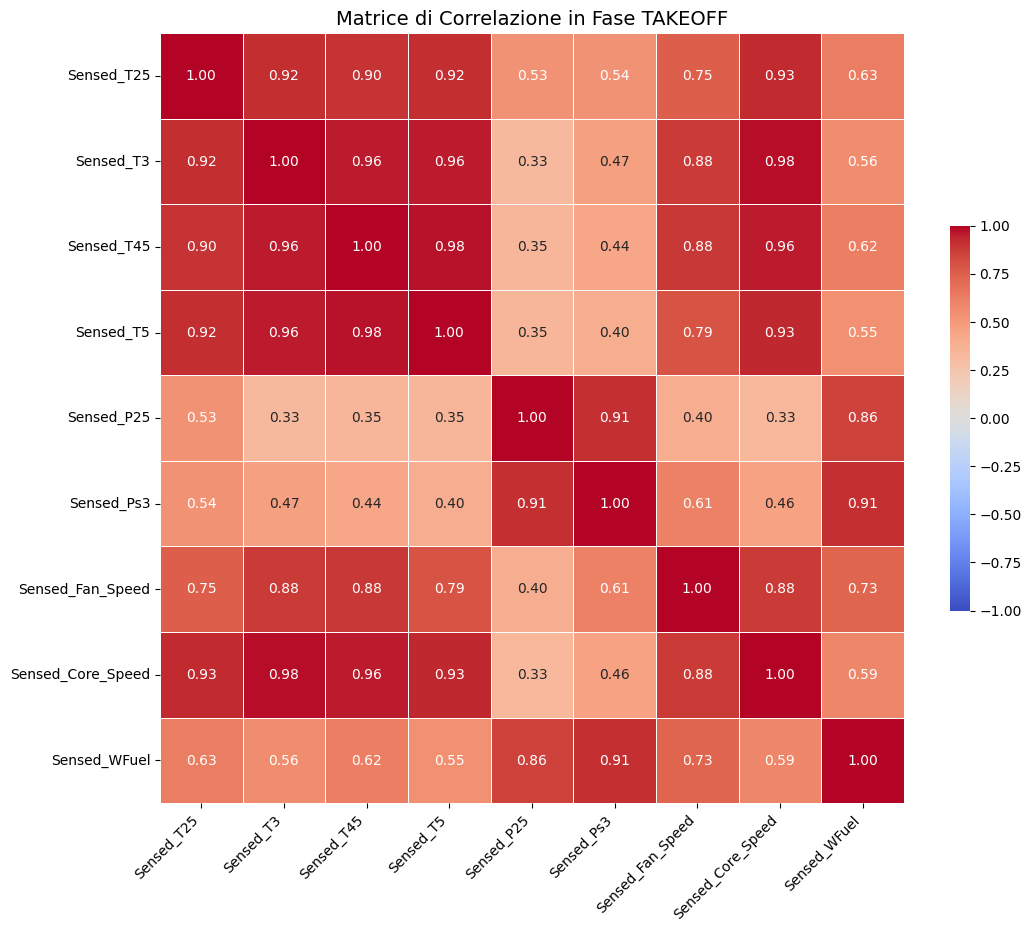


--- Matrice di Correlazione in Fase CLIMB (Dinamica) ---



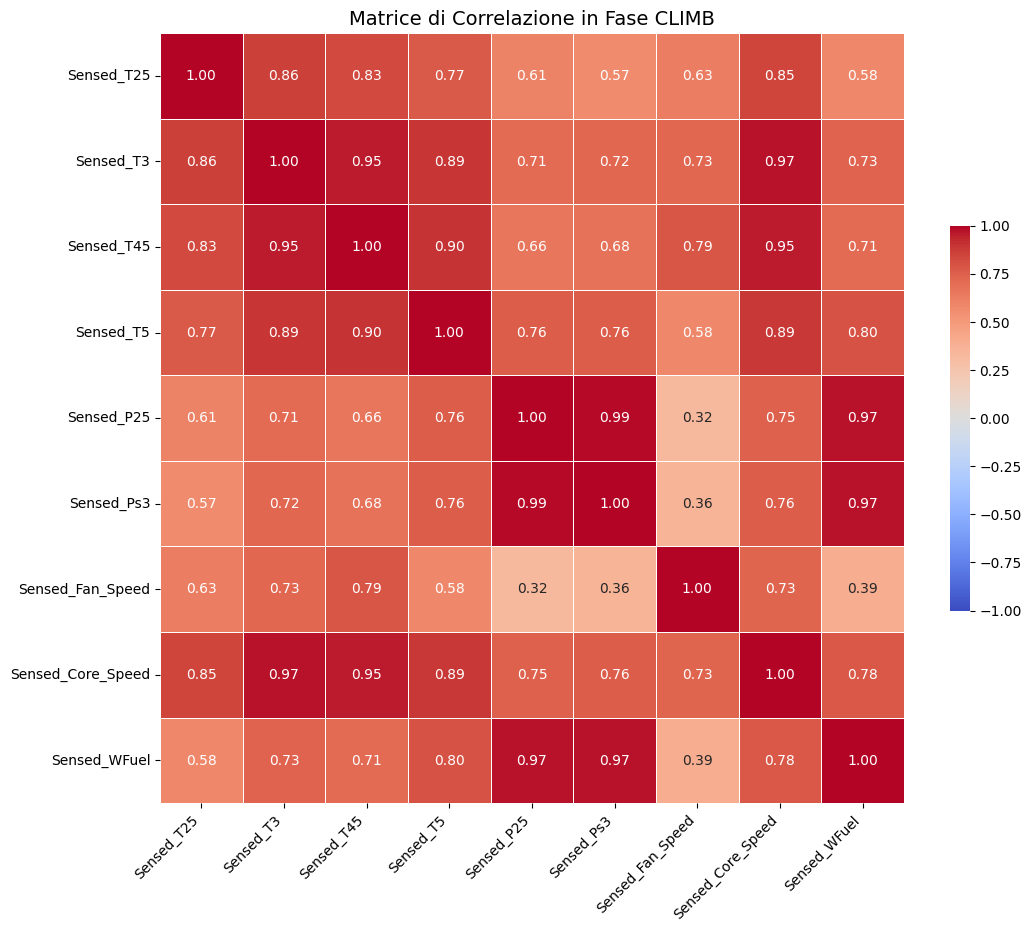


--- Matrice di Correlazione in Fase CRUISE (Stazionaria) ---



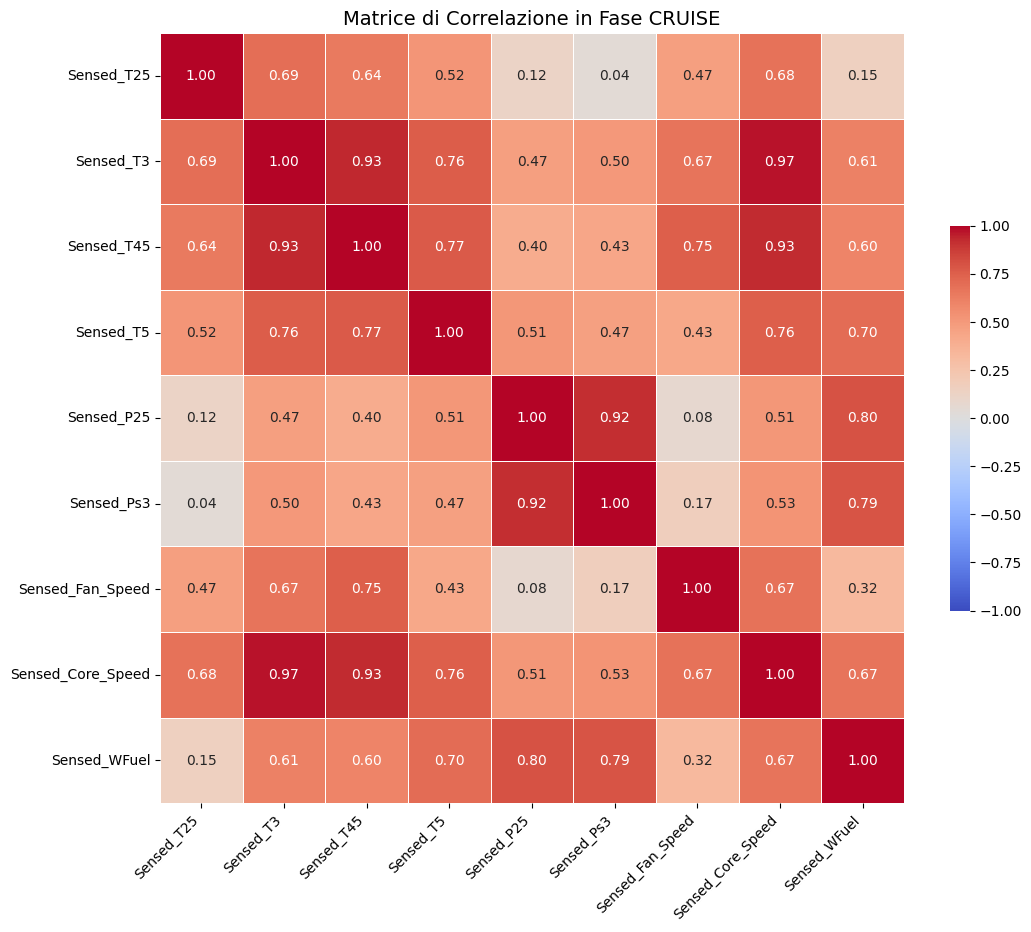


--- Matrice di Correlazione in Fase DESCENT (Dinamica) ---



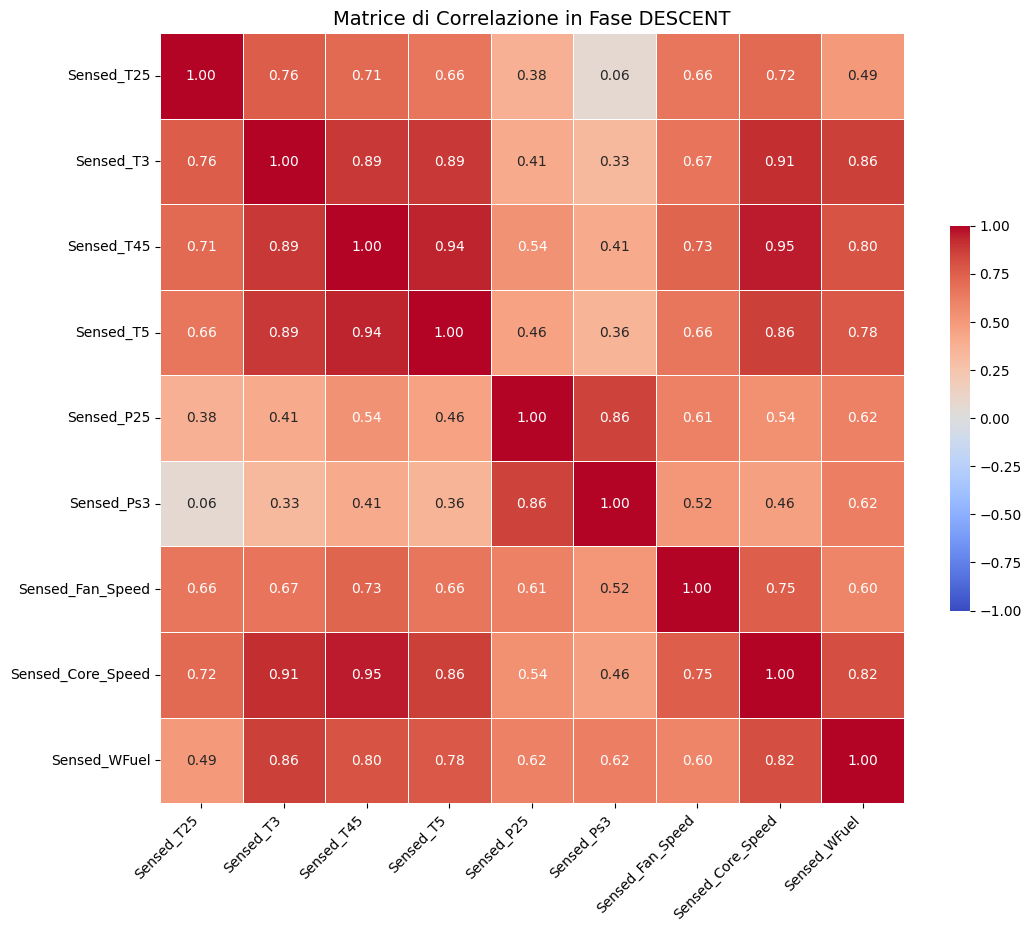

In [2]:
def analyze_phase_correlations(df, phase, sensors):
    """
    Calcola la matrice di correlazione per i sensori in una specifica fase di volo.
    """
    
    subset = df[df['Flight_Phase'] == phase][sensors].copy()
    
    if subset.empty:
        print(f"Nessun dato disponibile per la fase {phase}.")
        return
    
    # Calcolo Matrice di Correlazione
    corr_matrix = subset.corr()
    
    plt.figure(figsize=(12, 10))

    
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        center=0,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5}
    )
    
    plt.title(f"Matrice di Correlazione in Fase {phase}", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()
    
    return corr_matrix
    
sensors_to_correlate = [
        'Sensed_T25', 'Sensed_T3', 'Sensed_T45', 'Sensed_T5', 
        'Sensed_P25', 'Sensed_Ps3', 
        'Sensed_Fan_Speed', 'Sensed_Core_Speed', 
        'Sensed_WFuel'
]


print("\n--- Matrice di Correlazione in Fase TAKEOFF (Dinamica) ---\n")
takeoff_corr = analyze_phase_correlations(df_segmented, 'TAKEOFF', sensors_to_correlate)

print("\n--- Matrice di Correlazione in Fase CLIMB (Dinamica) ---\n")
climb_corr = analyze_phase_correlations(df_segmented, 'CLIMB', sensors_to_correlate)

print("\n--- Matrice di Correlazione in Fase CRUISE (Stazionaria) ---\n")
cruise_corr = analyze_phase_correlations(df_segmented, 'CRUISE', sensors_to_correlate)

print("\n--- Matrice di Correlazione in Fase DESCENT (Dinamica) ---\n")
descent_corr = analyze_phase_correlations(df_segmented, 'DESCENT', sensors_to_correlate)

#### **Fase TAKEOFF**
La Heatmap è un blocco solido di rosso scuro, indicando che le leggi della termodinamica sono rispettate rigorosamente. Questa fase è molto significativa per HPC.
- **Analisi Fisica - Ps3 vs P25 (0.91)**: le due pressioni in ingresso e uscita dell'HPC si muovono all'unisono. Se questa correlazione scende nel tempo, significa che il compressore sta perdendo efficienza (Water Wash necessario o danno).
- **Analisi Fisica - Ps3 vs WFuel (0.91)**: anche qui c'è una correlazione altissima. Per generare pressione serve carburante, quindi questa è la relazione input-output perfetta per calcolare l'efficienza.
- **Analisi Fisica - Core Speed vs T45 (0.96)**: la turbina (T45) sta guidando il compressore (Speed) al massimo sforzo.

Quindi, questa fase è perfetta per addestrare il modello sui guasti **HPC (Shop Visit & Water Wash)**.

#### **Fase CLIMB**
La Heatmap è molto simile al TAKEOFF, ma più pulita per le pressioni.
- **Analisi Fisica - Ps3 vs P25 (0.99)**: durante la salita la correlazione è quasi unitaria, con un rapporto ancora più stabile che al decollo.
- **Analisi Fisica - Ps3 vs WFuel (0.97)**: anche qui, ancora più alta che al decollo.

Quindi, se i dati di TAKEOFF fossero troppo pochi o rumorosi, la fase CLIMB è un **sostituto eccellente**, matematicamente anche più pulito per l'analisi **HPC**.

#### **Fase CRUISE**
La Heatmap è più sbiadita (grigio), indicando che molte correlazioni crollano.
- **Analisi Fisica - Ps3 vs Fan_Speed (0.17)**: Sembra che non siano legati, ma è falso. In crociera, la velocità della ventola è quasi costante. Le piccole variazioni di pressione ($P_{s3}$) qui dipendono dall'altitudine e dal Mach, non dalla ventola.
- **Analisi Fisica - T45 vs T3 (0.93)**: il legame termico in questa fase resiste, indicando che le temperature interne sono coerenti.
- **Analisi Fisica - WFuel vs Fan_Speed (0.32)**: in questo caso la correlazione è molto bassa, confermando che in crociera non si può predire il consumo basandosi solo sulla velocità della ventola.

Quindi, questa è una fase un po' difficile. Potrebbe essere **utile solo se i dati verranno normalizzati** (Residui), perché i dati grezzi sembrano casuali.

#### **Fase DESCENT**
La Heatmap corrisponde ad una "scacchiera": alcune coppie sono fortemente correlate, altre nulle.
- **Analisi Fisica - T45 vs Core_Speed (0.95)**: questo descrive come, anche a bassa potenza (discesa/idle), la temperatura della turbina è fortemente collegata alla velocità del core, descrivendo un legame termico puro, che non viene sporcato dalla pressione dell'aria esterna o dalla combustione violenta del decollo.

Questa fase, in conclusione, conferma l'analisi prognostica precedente: è **inutile per il compressore**, ma è **eccezionale per la Turbina (HPT)**. Il legame T45-Speed è stabile e pulito.

---

### **Analisi di Correlazione Fisica tra WFuel e Core_Speed**

In ambito aeronautico, basarsi sulla varianza globale di segnali grezzi (come il flusso di carburante, `WFuel`) per identificare anomalie può generare falsi positivi. Un motore perfettamente sano mostrerà un'alta varianza di `WFuel` semplicemente a causa delle variazioni di spinta richieste dalle diverse fasi di volo (decollo, salita, crociera).
Il degrado di un turbofan si manifesta fisicamente come una **perdita di efficienza termodinamica**. In termini pratici, questo significa che il motore deve bruciare più carburante per mantenere le stesse prestazioni (velocità di rotazione o spinta) rispetto a quando era nuovo.

In questa sezione si metterà in correlazione l'input energetico (`WFuel`) con la risposta meccanica (`Core_Speed`). Si utilizza uno scatter plot per osservare la **Curva Caratteristica di Consumo** di ogni motore. Mappando il colore dei punti in base alle diverse fasi di manutenzione, ci si aspetta di osservare se la curva del consumo specifico si alza o abbassa nelle varie fasi separate, senza il rumore degli altri dati.

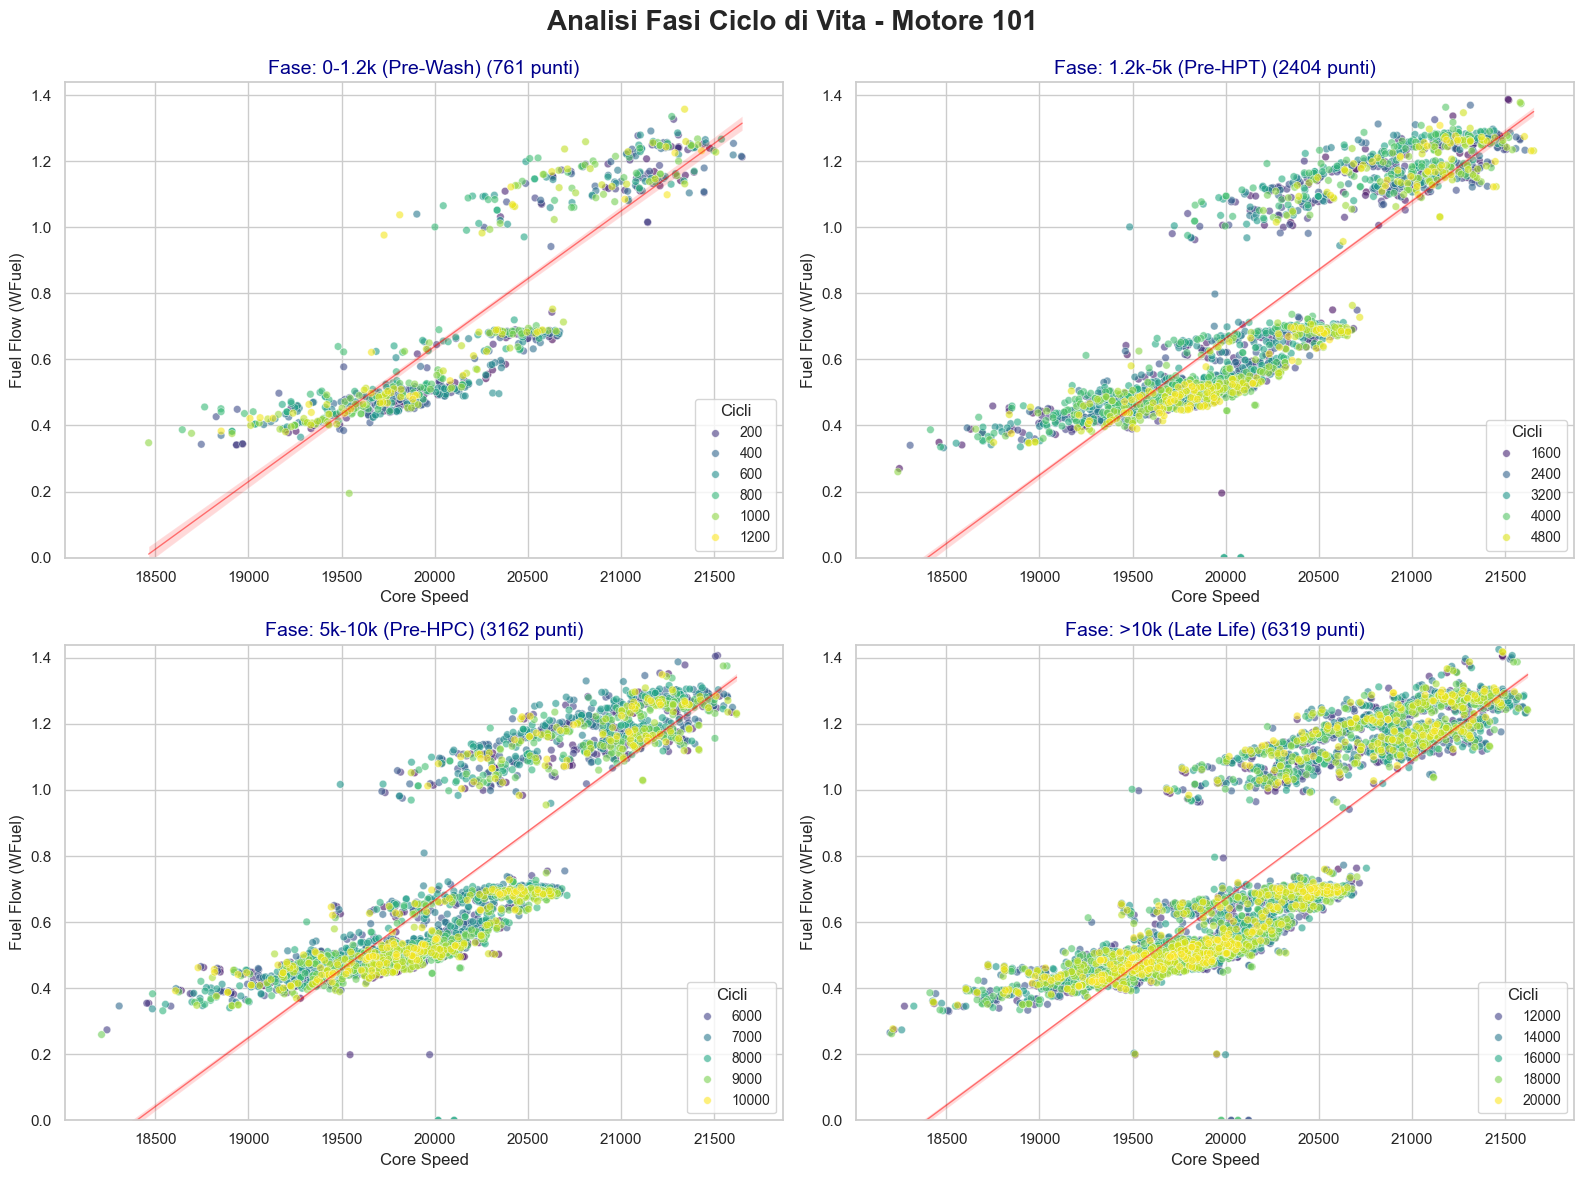

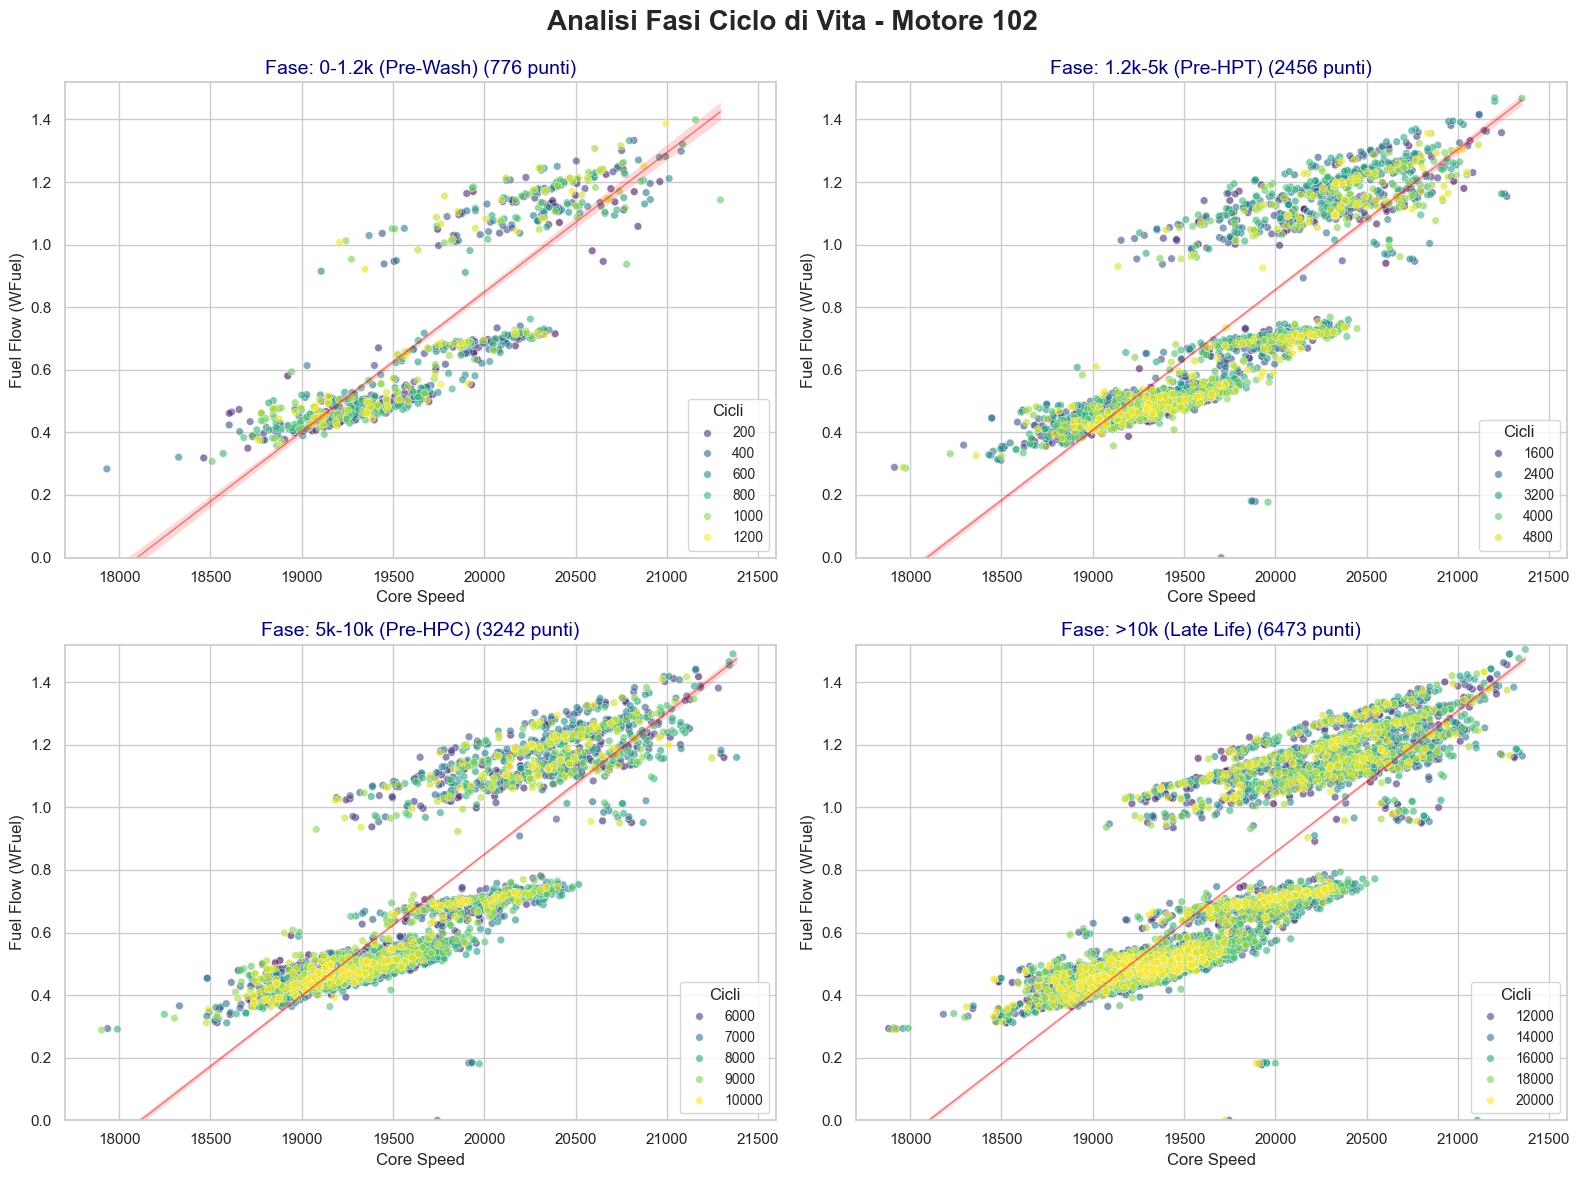

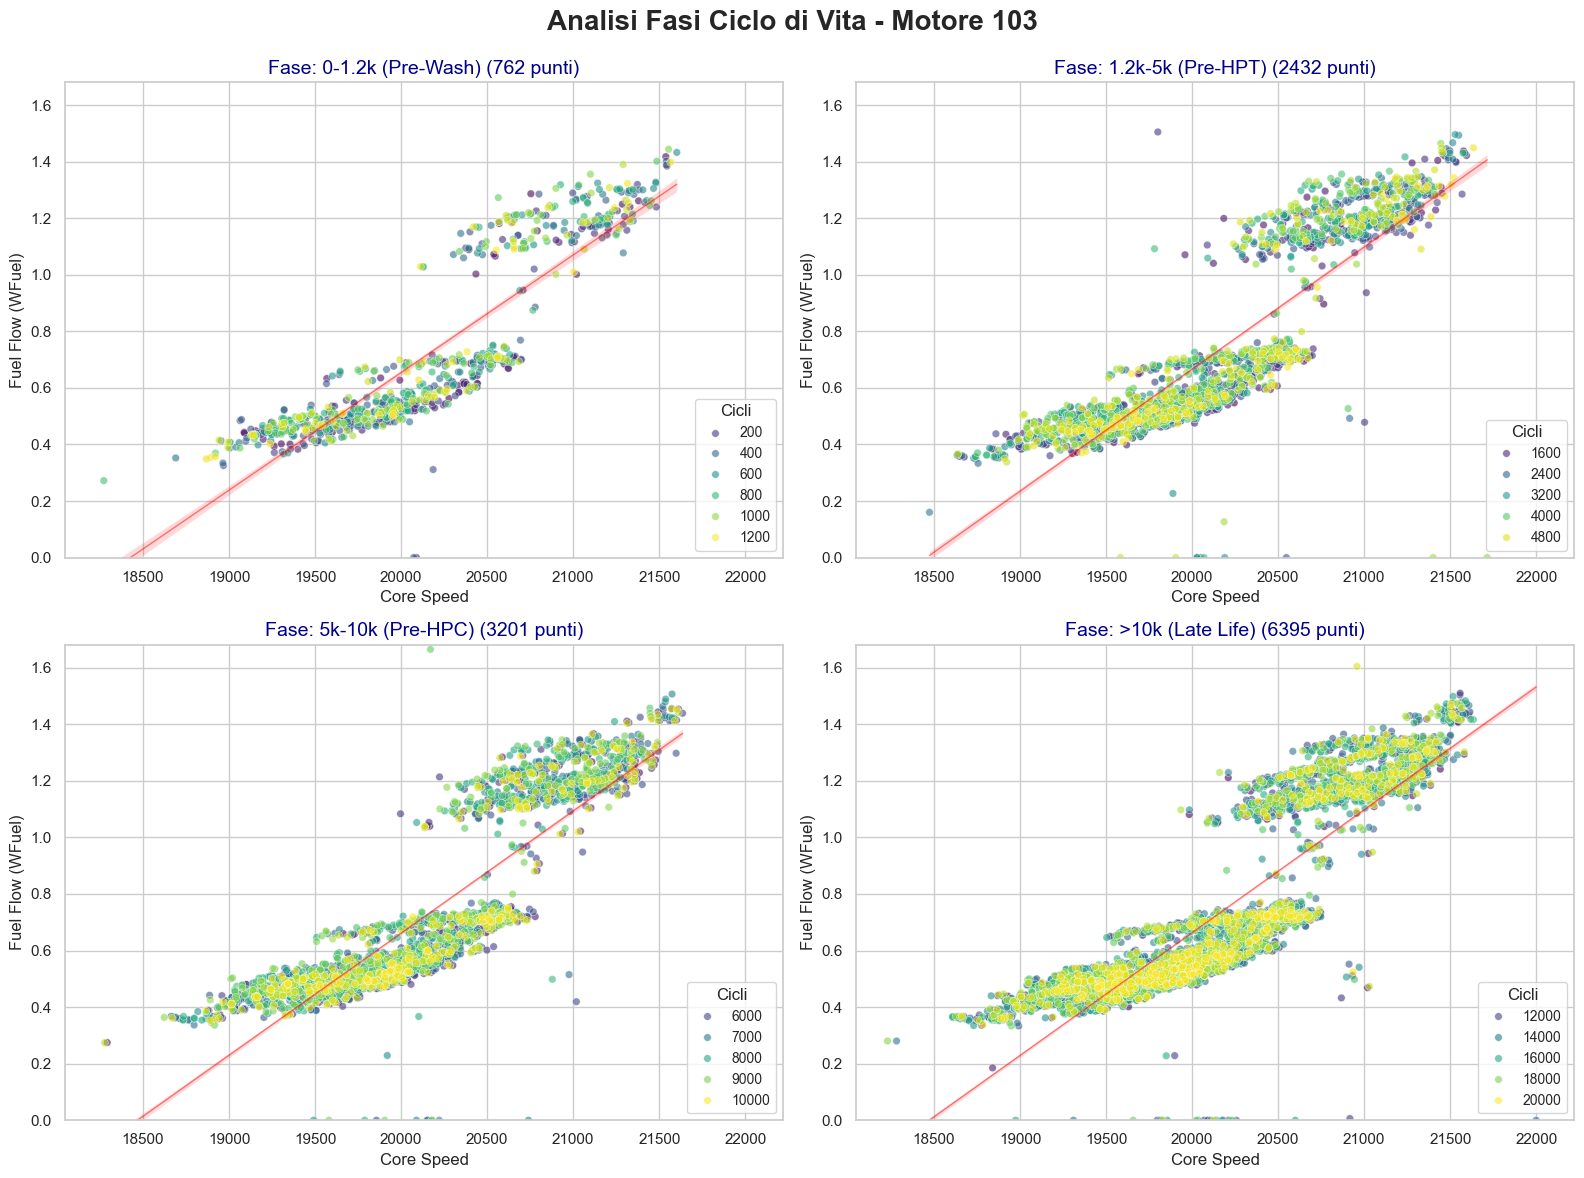

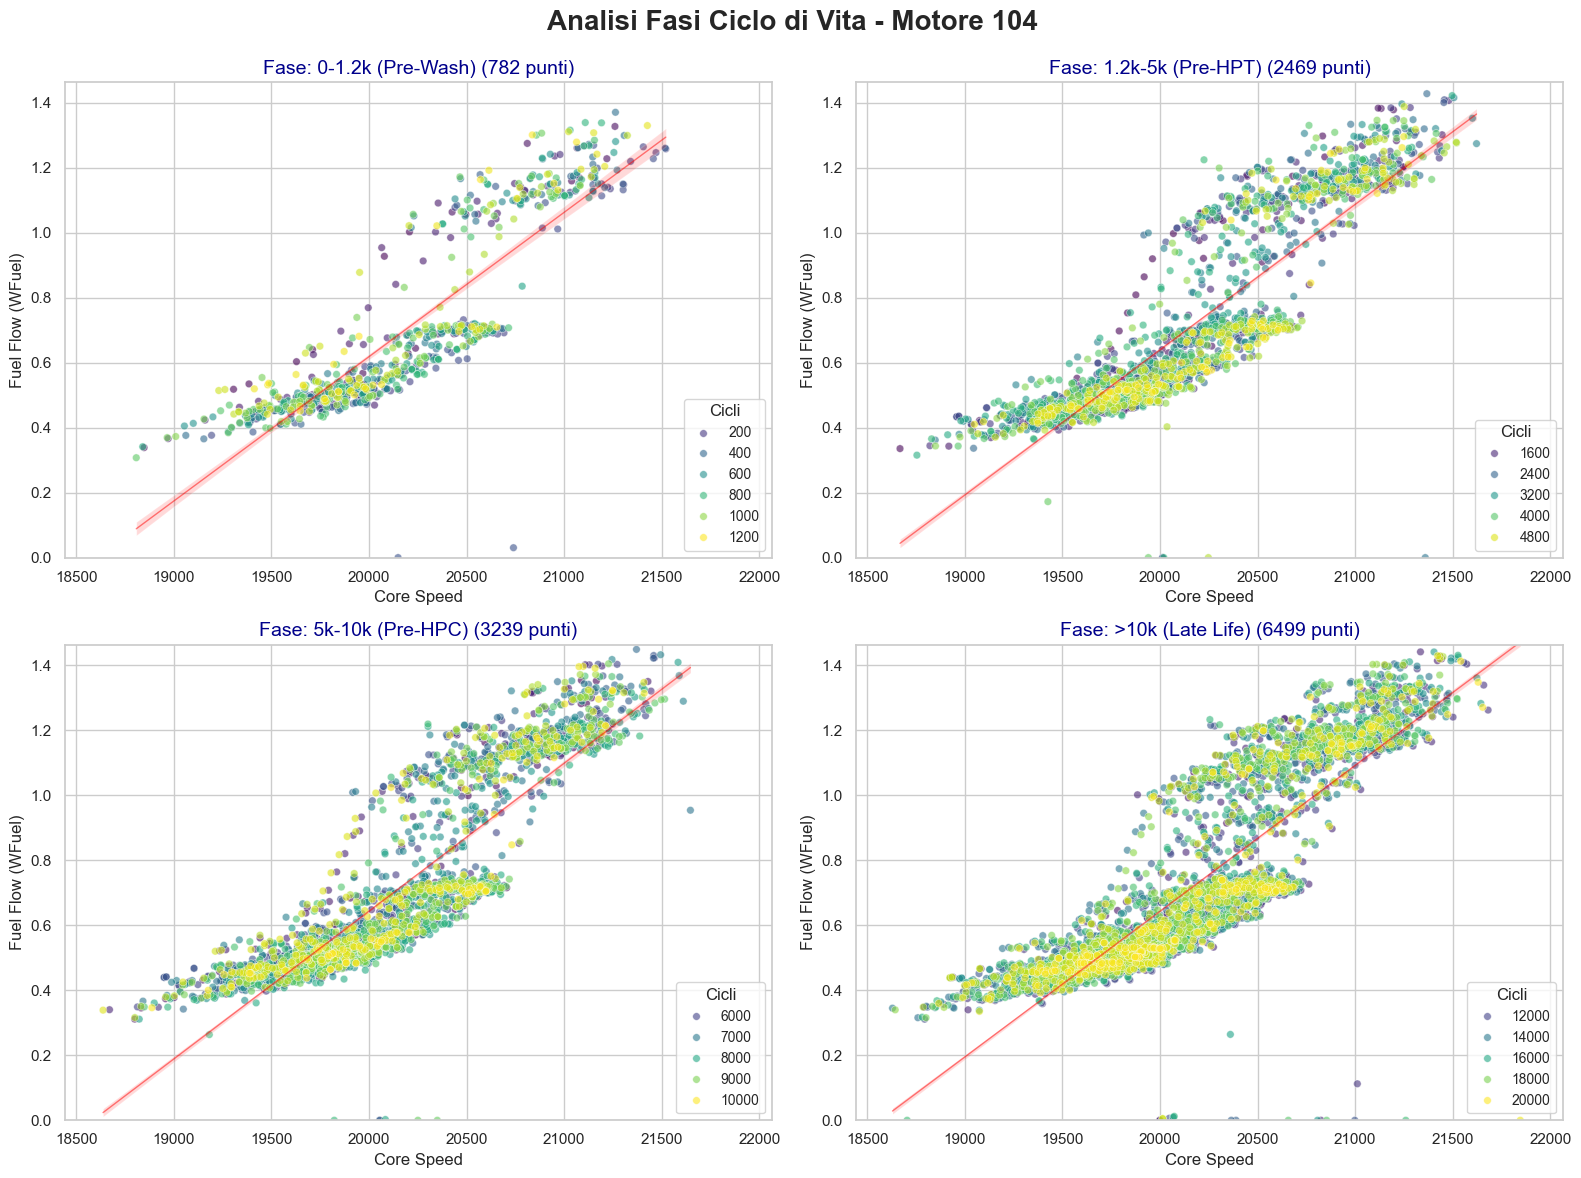

In [3]:
sns.set_theme(style="whitegrid")

# Preparazione Dati e Fasi
bins = [0, 1200, 5000, 10000, float('inf')]
labels = ['0-1.2k (Pre-Wash)', '1.2k-5k (Pre-HPT)', '5k-10k (Pre-HPC)', '>10k (Late Life)']

# Creazione di una colonna categorica
if 'Cycle_Phase' not in df_segmented.columns:
    df_segmented['Cycle_Phase'] = pd.cut(df_segmented['Cycles_Since_New'], bins=bins, labels=labels)

unique_units = df_segmented['ESN'].unique()

# Plotting per ogni motore
for unit in unique_units:
    df_unit = df_segmented[df_segmented['ESN'] == unit]
    
    # Calcolo dei limiti degli assi basati sul motore
    x_min, x_max = df_unit['Sensed_Core_Speed'].min(), df_unit['Sensed_Core_Speed'].max()
    y_min, y_max = df_unit['Sensed_WFuel'].min(), df_unit['Sensed_WFuel'].max()
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    axs = axs.flatten()
    
    fig.suptitle(f'Analisi Fasi Ciclo di Vita - Motore {unit}', fontsize=20, weight='bold')
    
    for i, phase in enumerate(labels):
        df_phase = df_unit[df_unit['Cycle_Phase'] == phase]
        
        ax = axs[i]
        
        if not df_phase.empty:
            # Scatterplot
            sns.scatterplot(
                data=df_phase,
                x='Sensed_Core_Speed',
                y='Sensed_WFuel',
                hue='Cycles_Since_New',
                palette='viridis',
                alpha=0.6,
                s=30,
                ax=ax
            )
            
            ax.set_title(f'Fase: {phase} ({len(df_phase)} punti)', fontsize=14, color='darkblue')
            
            # Linea di tendenza per vedere l'inclinazione
            sns.regplot(
                data=df_phase, 
                x='Sensed_Core_Speed', 
                y='Sensed_WFuel', 
                scatter=False, 
                ax=ax, 
                color='red', 
                line_kws={'linewidth':1, 'alpha':0.5}
            )
        else:
            ax.text(0.5, 0.5, 'Nessun dato per questa fase', 
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Fase: {phase}', fontsize=14)

        ax.set_xlim(x_min * 0.99, x_max * 1.01)
        ax.set_ylim(y_min * 0.99, y_max * 1.01)
        
        ax.set_xlabel('Core Speed')
        ax.set_ylabel('Fuel Flow (WFuel)')
        
        # Spostiamo la legenda fuori per pulizia
        if not df_phase.empty:
            ax.legend(title='Cicli', loc='lower right', fontsize='small')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

#### **Fasi del Motore 101**

La prima cosa che salta all'occhio sono le **due fasce distinte e separate** (caratteristiche che si ritroverà anche negli altri motori). La **linea rossa di regressione** passa esattamente in mezzo al vuoto tra le due fasce, indicando che il modello cerca di fare una media (probabilmente) tra due diverse modalità operative (ad esempio taxi vs cruise - alta quota vs bassa quota).

- **Fase 0-1.2k (Pre-Wash)**: questa è la situazione di **riferimento** (la baseline). In questo caso i punti sono ben definiti e le due fasce sono nette. La dispersione è minima (larghezza della nuvola), indicando che il comportamento del motore è coerente con un motore che dovrebbe essere nuovo.

- **Fase 1.2k-5k (Pre-HPT)**: la nuvola diventa molto più densa (quasi 3.000 punti). Non si nota uno spostamento verticale massiccio rispetto alla prima fase, quindi **il motore mantiene le prestazioni**. Si inizia a notare una leggera dispersione nella fascia superiore (`WFuel` > 1.0), ma i punti gialli sono ancora ben mascolati con quelli viola.

- **Fase 5k-10k (Pre-HPC)**: ci si aspetta un degrado molto più pesante, tuttavia il grafico mostra ancora una **notevole stabilità**. La fascia superiore rimane attorno agli stessi valori di `WFuel` per le velocità alte. Le operazioni di manutenzione intermedie sembrano aver funzionato bene nel contenere il degrado.

- **Fase >10k (Late Life)**: qui c'è la **massima densità** dei dati. Si osservano segnali di invecchiamento, essendo la nuvola superiore più spessa e disordinata. I punti gialli tendono a **rimanere più in alto o essere più sparsi** rispetto ai punti viola. Quindi, questo indicherebbe una **maggiore varianza nel consumo di carburante**. A parità di velocità, a volte il motore consuma un po' di più rispetto a quando era nuovo, sintomo di usura meccanica, ma non c'è un crollo catastrofico delle prestazioni.

#### **Confronto con gli altri motori**

Analizzando gli altri grafici si possono dividere i motori in due gruppi distinti in base al loro comportamento visivo.

- **Gruppo 101, 102, 103**: i Motori 102 e 103 sono **quasi indistinguibili** dal Motore 101. La bimodalità è netta, confermando che la separazione non è un'anomalia del Motore 101, ma una caratteristica strutturale di come questi motori vengono operati. Inoltre, in tutti e tre i motori le fase iniziali sono molto pulite. La fase `>10k` mostra lo stesso tipo di dispersione del Motore 101.

- **Motore 104**: la bimodale è **sporca/assente**. Infatti, lo spazio vuoto tra le due fasce è pieno di punti. La nuvola ha una forma molto più a curva e continua rispetto alle due linee parallele degli altri motori. Questo potrebbe indicare che **il motore vola profili di missione diversi**, oppure potrebbe indicare una calibrazione diversa dei sensori, rendendo meno netto il passaggio tra i due regimi operativi. Inoltre, nella fase `>10k` la nuvola sembra ancora più densa e disordinata.

Quindi, è possibile aggiungere una nuova feature `W_Core_Ratio` espressa come il rapporto tra `Sensed_WFuel` e `Sensed_Core_Speed`, un indicatore diretto **dell'efficienza Termodinamica del Motore**. Questa feature mira a linearizzare il degrado, isolando l'efficacia dal regime di funzionamento istantaneo.
Per dei valori bassi, il motore è efficiente (gira veloce con poco carburante); al contrario un valore alto indica un'inefficienza del motore (brucia più carburante per mantenere la stessa velocità).

In [4]:
# Creazione colonna W_Core_Ratio
df_segmented["W_Core_Ratio"] = df_segmented["Sensed_WFuel"] / df_segmented["Sensed_Core_Speed"]

print(df_segmented[["Sensed_WFuel", "Sensed_Core_Speed", "W_Core_Ratio"]].head())

   Sensed_WFuel  Sensed_Core_Speed  W_Core_Ratio
0      1.231128       21280.040466      0.000058
1      1.095966       21014.282876      0.000052
2      0.685568       20466.466115      0.000033
3      0.623099       20313.501657      0.000031
4      0.488970       19760.214983      0.000025


--- 

### **Analisi dei Residui**

L'analisi dei dati grezzi in un sistema complesso come motori di aerei presenta il problema del **mascheramento**: i valori misurati dai sensori variano principalmente a causa delle **condizioni operative** e solo la minima parte a causa del degrado reale del componente. Si prosegue quindi con **un'analisi dei residui** per normalizzare il comportamento del motore rispetto alle condizioni in cui sta volando, cancellando la variabilità operativa. Ciò che rimane (il residuo) non è più influenzato da dove o come si sta volando, ma dipende esclusivamente dallo **stato di salute** del componente.

Di seguito, viene introdotta una funzione per il calcolo dei residui dando come parametro le colonne da usare come input.

In [5]:
def calculate_residuals(df_input, features, target, phases_list, resid_col_name, baseline_cycles=100):
    """
    Funzione Universale per il calcolo dei residui (Health Monitoring).

    Args:
        df_input (pd.DataFrame): Il dataset completo.
        features (list): Le colonne da usare come input (X).
        target (str): La colonna da predire (y).
        phases_list (list): Lista delle fasi su cui calcolare (es. ['CLIMB'] o ['CLIMB', 'TAKEOFF']).
        resid_col_name (str): Nome da dare alla colonna del risultato (es. 'HPC_Resid').
        baseline_cycles (int): Numero di cicli per l'addestramento (default 100).
    """
    df = df_input.copy()
    all_results = []

    unique_engines = df['ESN'].unique()
    print(f"--- Analisi: {resid_col_name} ---")
    print(f"Target: {target} | Features: {features}")
    print(f"Motori: {len(unique_engines)} | Fasi: {phases_list}")

    for phase in phases_list:

        for esn in unique_engines:
            # 1. Filtro Dati
            df_eng = df[(df['ESN'] == esn) & (df['Flight_Phase'] == phase)].copy()

            if df_eng.empty: continue

            # 2. Addestramento (Baseline)
            baseline_mask = df_eng['Cycles_Since_New'] <= baseline_cycles
            df_train = df_eng[baseline_mask].dropna(subset=features + [target])

            # Minimo punti per validità statistica
            if len(df_train) < 10:
                continue

            # Modello
            model = LinearRegression()
            model.fit(df_train[features], df_train[target])

            # 3. Predizione (Gestione NaN con ffill/bfill/0)
            X_all = df_eng[features].fillna(method='ffill').fillna(method='bfill').fillna(0)
            expected_val = model.predict(X_all)

            # 4. Calcolo Residuo
            # Nota: Residuo = Reale - Atteso
            df_eng[resid_col_name] = df_eng[target] - expected_val

            # 5. Aggregazione per Ciclo
            cycle_res = df_eng.groupby('Cycles_Since_New')[resid_col_name].mean().reset_index()
            cycle_res['ESN'] = esn
            cycle_res['Phase'] = phase

            all_results.append(cycle_res)

    if len(all_results) > 0:
        return pd.concat(all_results, ignore_index=True)
    else:
        print(f"ATTENZIONE: Nessun dato calcolato per {resid_col_name}")
        return pd.DataFrame()

#### **Health Indicator HPC (Residuo HPC)**

Sulla base di questa logica, è stato sviluppato un **Health Indicator** specifico per il HPC, transformando le correlazioni fisiche in un indice numerico di degrado.

La metodologia si basa sulla creazione di un **modello ideale** del motore che predice come dovrebbe comportarsi un componente sano nelle attuali condizioni di volo. Viene scelta come **baseline** i primi **100 cicli** di vita, per poi addestrare un **Modello di Regressione Lineare** per apprendere la relazione fisica ideale durante la fase di TAKEOFF e CLIMB:

$$Ps3_{attesa} = f(P25, Core\_Speed)$$

Per isolare l'efficienza del compressore il modello controlla rigorosamente le due variabili di **input** che ne determinano la performance:
- **Pressione in ingresso (`Sensed_P25`)**: serve a normalizzare il carico. Poiché l'HPC moltiplica la pressione in ingresso, se l'aereo sale di quota e $P25$ scende (aria rarefatta), il modello sa che anche $Ps3$ deve scendere, evitando falsi allarmi.

- **Velocità di rotazione (`Sensed_Core_Speed`)**: serve a quantificare il lavoro meccanico. Più veloce gira il motore, più alta deve essere la pressione attesa.

L'Health Indicator è calcolato come la differenza tra la realtà misurata e la predizione fisica:

$$Residuo = Ps3_{reale} - Ps3_{attesa}$$

- Residuo ≈ 0: il motore opera esattamente come quando era nuovo.
- Residuo negativo: a parità di aria in ingresso ($P25$) e di sforzo meccanico ($Speed$), il compressore genera meno pressione di uscita ($Ps3$).

--- Analisi: HPC_Resid ---
Target: Sensed_Ps3 | Features: ['Sensed_P25', 'Sensed_Core_Speed']
Motori: 4 | Fasi: ['CLIMB', 'TAKEOFF']
Generazione grafici per i motori: [101 102 103 104]


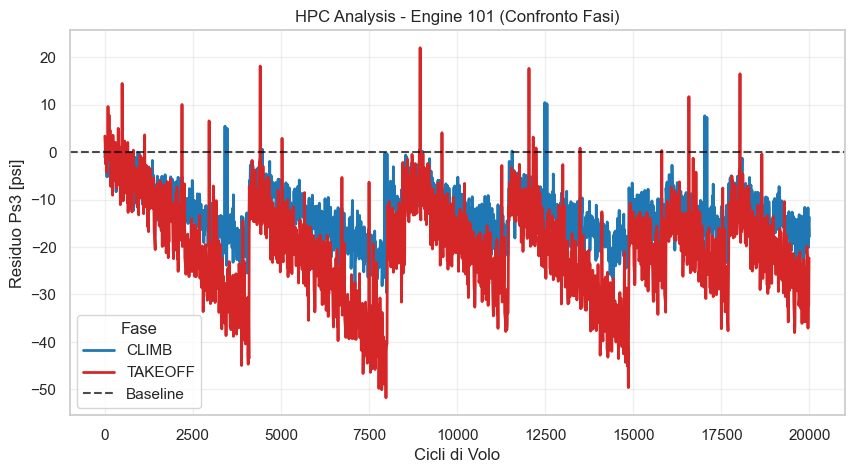

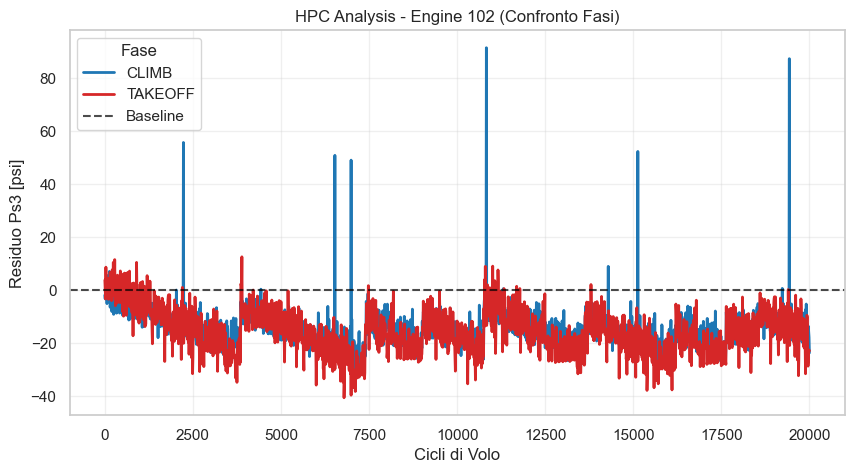

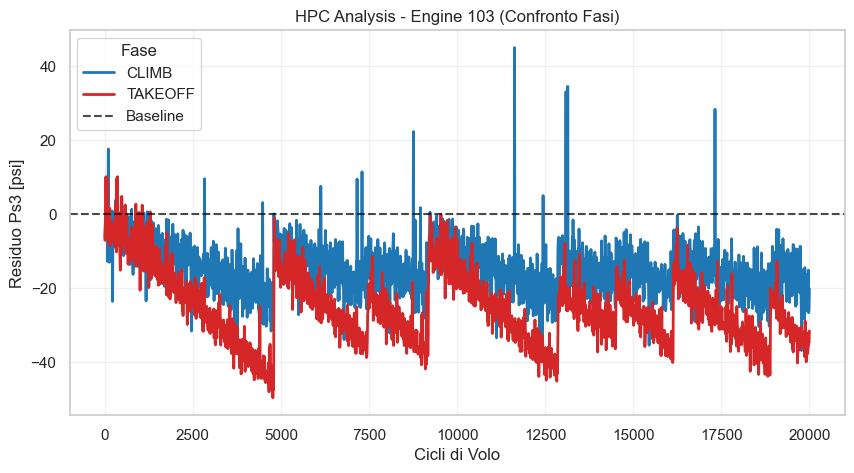

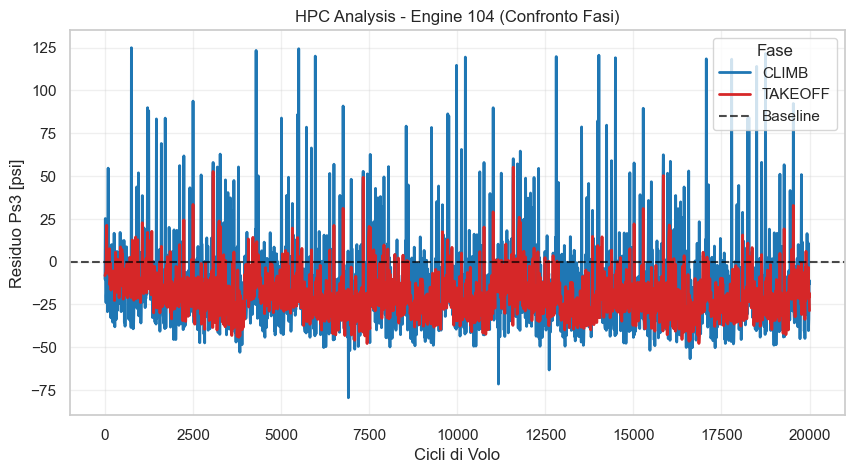

In [6]:
# --- CONFIGURAZIONE HPC ---
hpc_features = ['Sensed_P25', 'Sensed_Core_Speed']
hpc_target = 'Sensed_Ps3'
hpc_phases = ['CLIMB', 'TAKEOFF']

# Esecuzione
df_res_hpc = calculate_residuals(
    df_input=df_segmented,
    features=hpc_features,
    target=hpc_target,
    phases_list=hpc_phases,
    resid_col_name='HPC_Resid'
)

# --- VISUALIZZAZIONE HPC ---
if not df_res_hpc.empty:
    unique_engines = df_res_hpc['ESN'].unique()[:4]

    print(f"Generazione grafici per i motori: {unique_engines}")

    for esn in unique_engines:
        subset = df_res_hpc[df_res_hpc['ESN'] == esn]

        plt.figure(figsize=(10, 5))

        sns.lineplot(
            data=subset,
            x='Cycles_Since_New',
            y='HPC_Resid',
            hue='Phase',
            linewidth=2,
            palette={'CLIMB': 'tab:blue', 'TAKEOFF': 'tab:red'}
        )

        plt.title(f"HPC Analysis - Engine {esn} (Confronto Fasi)")
        plt.ylabel("Residuo Ps3 [psi]")
        plt.xlabel("Cicli di Volo")
        plt.axhline(0, color='black', linestyle='--', alpha=0.7, label='Baseline')
        plt.legend(title='Fase')
        plt.grid(True, alpha=0.3)
        plt.show()

else:
    print("Nessun dato HPC disponibile per la visualizzazione.")


**Analisi Macro: Confronto tra CLIMB e TAKEOFF**

In quasi tutti i motori (101,102,103) la linea rossa (TAKEOFF) è **costantemente più bassa** (più negativa) della linea blu (CLIMB). Ciò significa che il TAKEOFF è la fase di massimo stress meccanico e termico, indicando che questa fase **è molto più sensibile** al degrado dell'HPC rispetto alla fase CLIMB.
Quindi, per la rilevazione dei primi segni di guasto, si dovrebbe utilizzare il **Residuo del TAKEOFF**, perché la fase CLIMB tende a sottostimare il problema, mostrando un residuo meno grave.

**Identificazione dei Target di Manutenzione**

I grafici mostrano le firme dei due eventi di manutenzione HPC da predirre nella challenge.

- **HPC Water-Wash (forma di Dente a sega)**: si può osservare, ad esempio nei Motori 101 e 103, che il residuo scende lentamente per un periodo, poi improvvisamente torna con un salto verticale verso l'alto quasi a zero. La **discesa lenta è l'accumulo di sporcizia**, il **salto improvviso è l'evento di Water-Wash** di pulizia del compressore.

- **HPC Shop Visit**: anche dopo un Water-Wash il motore non torna mai perfetto come da nuovo. Questo è osservabile dai picchi alti dopo ogni lavaggio, il cui valore **scende dopo ogni lavaggio** (Ciclo 100 - Residuo = 0 psi, Ciclo 4500 - Residuo = -5 psi, Ciclo 17000 - Residuo = -15 psi). La differenza tra lo zero ideale e il punto massimo di recupero dopo il lavaggio è il **degrado irreversibile** (erosione, usura guarnizioni). Il trend a lungo termine di questi "massimi locali" è quello che **predice l'HPC Shop Visit**. Quando nemmeno il lavaggio riesce a riportare il residuo sopra una certa soglia critica (es. -20 psi), il motore deve andare in officina.

**Anomalia del Motore 104**

Come già osservato nelle analisi precedenti, questo motore ha un comportamento completamente diverso e rappresenta un problema critico per i dati. Il grafico mostra una **scala molto più grande** (+125 a -75 psi VS +20 a -50 psi), oltre che **un segnale molto più rumoroso**, descrivendo un trend poco chiaro, con oscillazioni violente e simmetriche intorno allo zero. Quindi, il modello fisico non sta funzionando per questo motore, probabilmente per un guasto del sensore o per instabilità meccanica.

#### **Health Indicator HPT (Residuo HPT)**

Mentre l'HPC si degrada perdendo pressione, la **Turbina di Alta Pressione (HPT)** manifesta degrado principalmente attraverso **l'efficienza termica**.

Anche qui le fasi operative saranno TAKEOFF e CLIMB (massimo stress termico continuativo), prevedendo la temperatura di uscita  $T45$ basandoci sulla velocità del motore e sulla pressione in ingresso:

$$T_{45\_attesa} = f(Core\_Speed, P_{25})$$

Il residuo verrà calcolato quindi facendo la differenza tra il valore reale ed il valore atteso:

$$Residuo = T_{45\_reale} - T_{45\_attesa}$$

A differenza del compressore (dove il residuo **scende**), qui ci si aspetta un **residuo crescente (positivo)**, che significa come il motore stia girando più caldo di quanto dovrebbe per quel punto operativo. Questo è un fenomeno noto come **EGT Margin Deterioration** ed è l'indicatore principale per vedere la necessità di manutenzione alla sezione calda.

--- Analisi: HPT_Resid ---
Target: Sensed_T45 | Features: ['Sensed_Core_Speed', 'Sensed_P25']
Motori: 4 | Fasi: ['CLIMB', 'TAKEOFF']
Generazione grafici HPT (Climb + Takeoff) per i motori: [101 102 103 104]


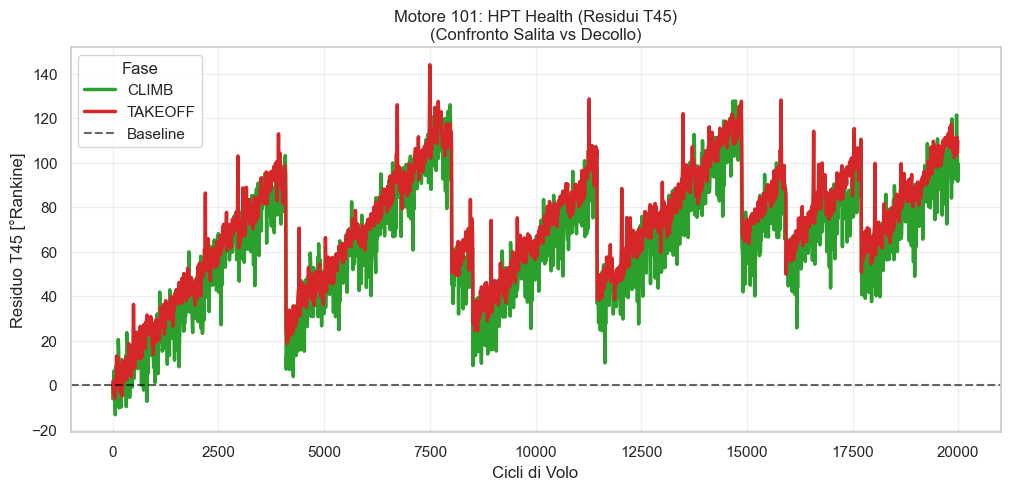

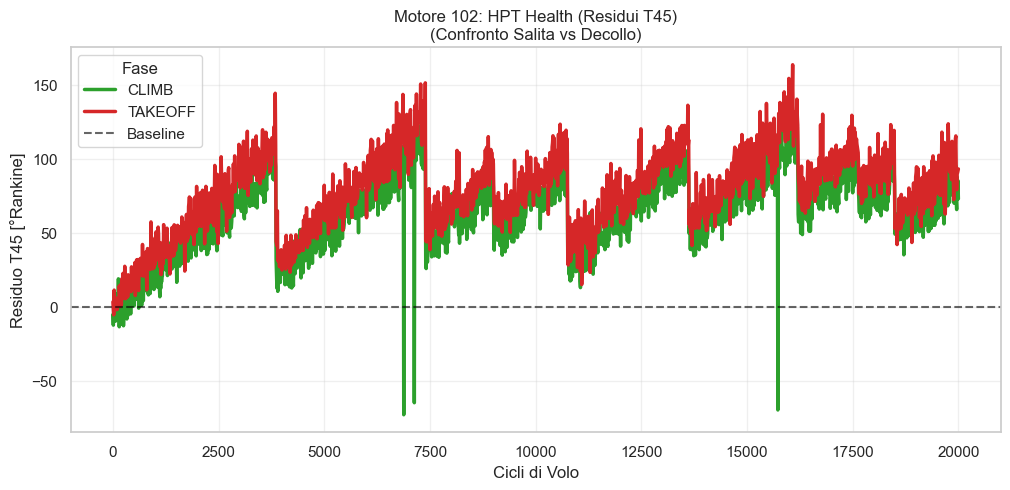

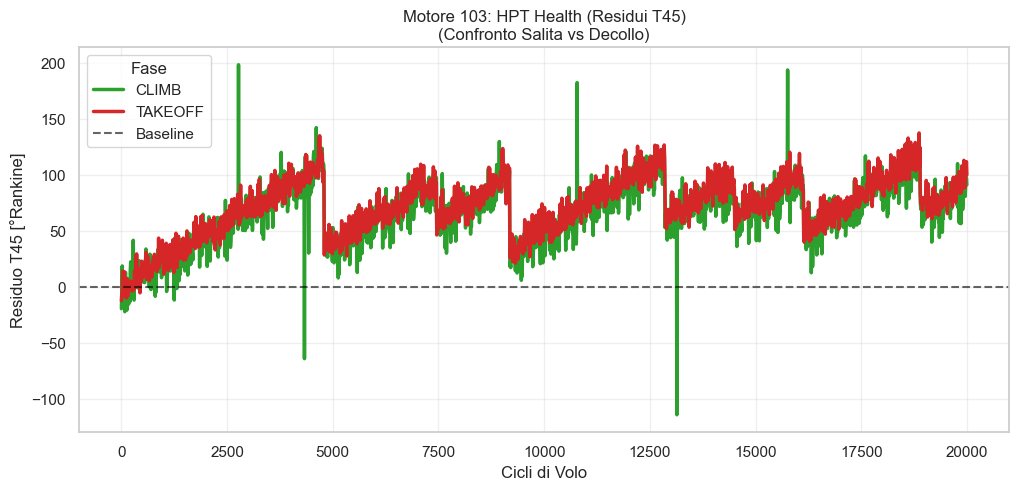

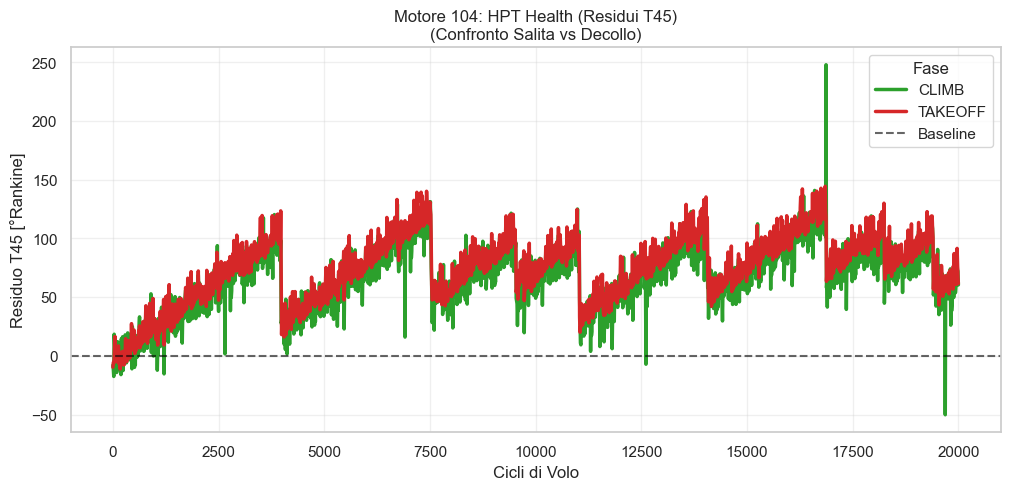

In [7]:
# --- CONFIGURAZIONE HPT---
hpt_features = ['Sensed_Core_Speed', 'Sensed_P25']
hpt_target = 'Sensed_T45'
hpt_phases = ['CLIMB', 'TAKEOFF']

# Esecuzione
df_res_hpt = calculate_residuals(
    df_input=df_segmented,
    features=hpt_features,
    target=hpt_target,
    phases_list=hpt_phases,
    resid_col_name='HPT_Resid'
)

# --- VISUALIZZAZIONE HPT ---
if not df_res_hpt.empty:
    unique_engines = df_res_hpt['ESN'].unique()[:4]

    print(f"Generazione grafici HPT (Climb + Takeoff) per i motori: {unique_engines}")

    for esn in unique_engines:
        subset = df_res_hpt[df_res_hpt['ESN'] == esn]

        plt.figure(figsize=(12, 5))

        sns.lineplot(
            data=subset,
            x='Cycles_Since_New',
            y='HPT_Resid',
            hue='Phase',
            linewidth=2.5,
            palette={'CLIMB': 'tab:green', 'TAKEOFF': 'tab:red'}
        )

        plt.axhline(0, color='black', linestyle='--', alpha=0.6, label='Baseline')

        plt.title(f"Motore {esn}: HPT Health (Residui T45)\n(Confronto Salita vs Decollo)")
        plt.ylabel("Residuo T45 [°Rankine]")
        plt.xlabel("Cicli di Volo")
        plt.legend(title='Fase')
        plt.grid(True, alpha=0.3)
        plt.show()

else:
    print("Nessun dato HPT disponibile.")

**Trend Positivo**

A differenza del grafico HPC le linee si confermano **salire costantemente** sopra lo zero come atteso. A parità di velocità e aria in ingresso il motore diventa più caldo di 100-150 gradi rispetto a quando era nuovo, descrivendo il suddetto fenomeno EGT Margin Deterioration. La turbina è "cotta" (pale erose o rivestimenti termici andati), quindi estrae meno lavoro dal gas. Per mantenere i giri, il computer del motore deve bruciare più carburante, alzando la temperatura $T_{45}$.

**Eventi di manutenzione (Dente a sega)**

Come per l'HPC, si può notare come il residuo crolla improvvisamente da un valore alto (+100) a uno basso (+20). Questo conferma uno **Shop Visit** o manutenzione maggiore. Hanno smontato il motore, sostituito le parti calde degradate e il motore ha "recuperato" efficienza (è tornato più freddo).

**Shift di Carico**

In tutti i grafici la linea rossa (TAKEOFF) è **sistematicamente più alta** della linea verde (CLIMB), con offset positivo costante. Quando una turbina è degradata (pale erose), l'inefficienza non è lineare. Più spingi il motore al limite, più l'inefficienza si amplifica. Quindi, il TAKEOFF è un **amplificatore di segnale migliore**. Il guasto è più evidente (il numero è più grande) durante il decollo rispetto alla salita.

#### **Global Thermal Health Indicator (Residui T_45)**

L'obiettivo è **monitorare l'efficienza complessiva del ciclo termodinamico** del motore in condizioni di CRUISE, predicendo la temperatura di scarico ideale in base alla temperatura di ingresso alla camera di combustione. Secondo questa logica, esiste una relazione fisica diretta tra la temperatura dell'aria compressa ($T_3$) e quella dei gas espansi ($T_{45}$). In un motore sano, questa relazione è fissa.

$$T_{45\_attesa} = f(T_3)$$

Il calcolo del residuo avviene tramite la differenza tra la temperatura in ingresso reale e quella predetta.

$$Residuo = T_{45\_reale} - T_{45\_attesa}$$

Anche qui ci si aspetta un **residuo crescente (positivo)**.
Se il motore perde efficienza globale (sia nel compressore che nella turbina), tenderà a trattenere più calore nei gas di scarico ($T_{45}$ più alta del previsto) invece di convertirlo in spinta utile. Questo residuo è un ottimo indicatore di "salute generale" del motore.

--- Analisi: Global_Resid ---
Target: Sensed_T45 | Features: ['Sensed_T3']
Motori: 4 | Fasi: ['CRUISE']
Generazione grafici Global Cruise per i motori: [101 102 103 104]


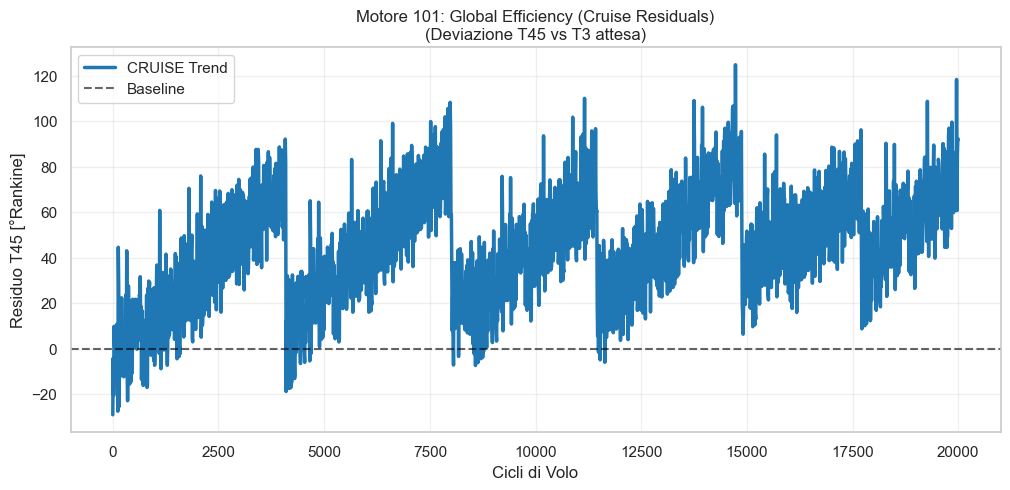

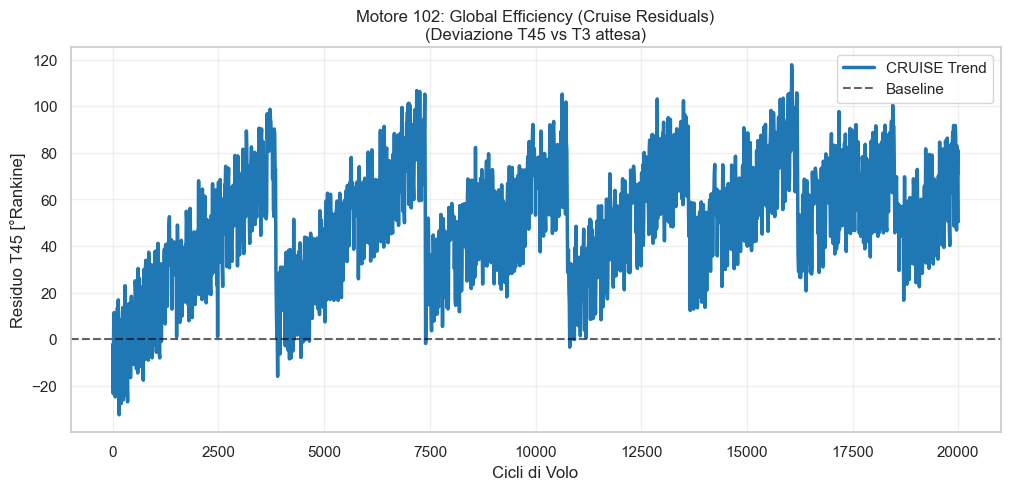

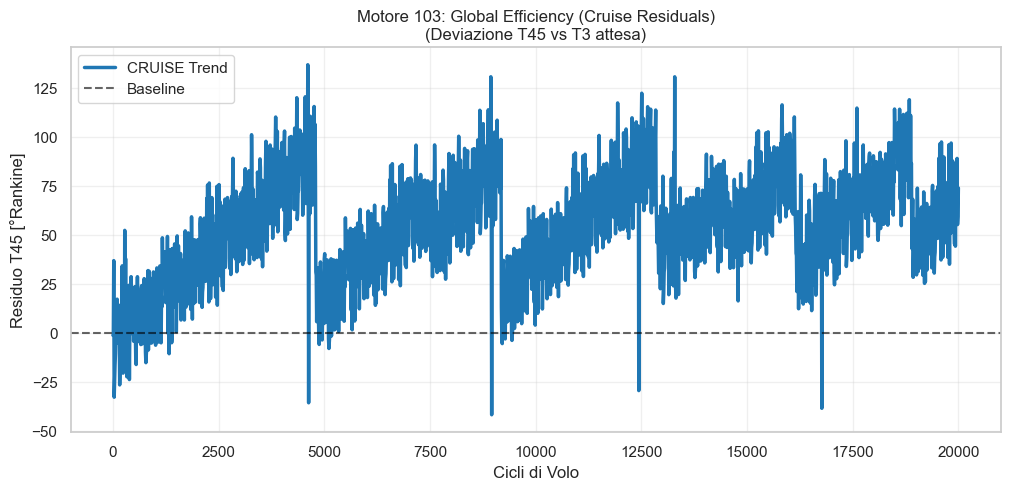

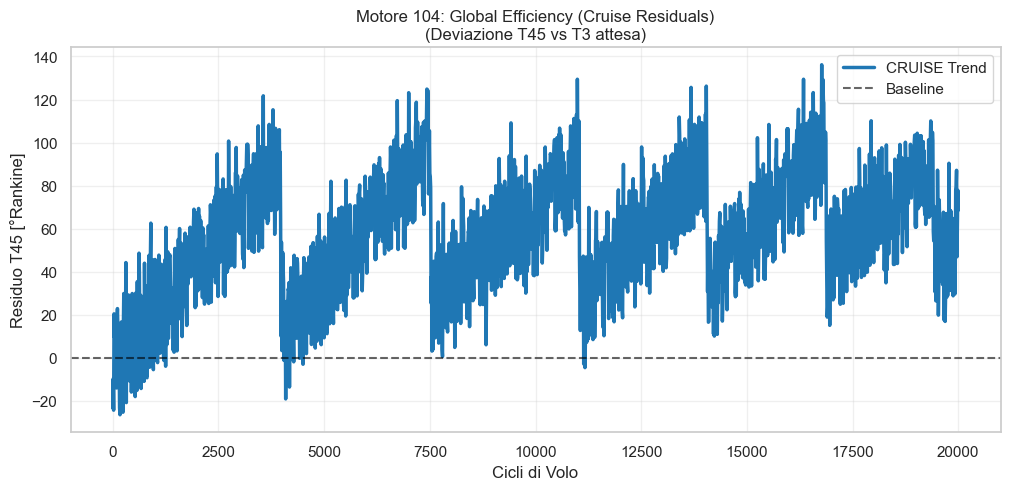

In [8]:
# --- CONFIGURAZIONE GLOBAL ---
global_features = ['Sensed_T3']
global_target = 'Sensed_T45'
global_phases = ['CRUISE']

# Esecuzione
df_res_global = calculate_residuals(
    df_input=df_segmented,
    features=global_features,
    target=global_target,
    phases_list=global_phases,
    resid_col_name='Global_Resid'
)

# Visualizzazione Global
if not df_res_global.empty:
    unique_engines = df_res_global['ESN'].unique()[:4]

    print(f"Generazione grafici Global Cruise per i motori: {unique_engines}")

    for esn in unique_engines:
        subset = df_res_global[df_res_global['ESN'] == esn]

        plt.figure(figsize=(12, 5))

        sns.lineplot(
            data=subset,
            x='Cycles_Since_New',
            y='Global_Resid',
            color='tab:blue',
            linewidth=2.5,
            label='CRUISE Trend'
        )

        plt.axhline(0, color='black', linestyle='--', alpha=0.6, label='Baseline')

        plt.title(f"Motore {esn}: Global Efficiency (Cruise Residuals)\n(Deviazione T45 vs T3 attesa)")
        plt.ylabel("Residuo T45 [°Rankine]")
        plt.xlabel("Cicli di Volo")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

else:
    print("Nessun dato Global disponibile.")

**Costo dell'invecchiamento**

Osservando il grafico si può notare subito che il trend è positivo e crescente.
Tutti i motori partono approssimativamente da 0, **confermando** la baseline.
Man mano che i cicli aumentano, il residuo sale fino a +100/+125 gradi. Ciò significa che, a parità di temperatura di ingresso camera di combustione, un motore vecchio sputa fuori gas **molto più caldi** di un motore nuovo. Quindi, il motore sta perdendo la capacità di convertire l'energia termica (calore) in energia meccanica (lavoro). Il calore "in eccesso" non viene usato per far girare la turbina, ma viene sprecato nello scarico.

**Osservazioni specifiche sui motori**

Per il Motore 102 si possono osservare i punti di "atterraggio" dopo ogni crollo (minimi locali):

- Ciclo ~4.000: il residuo scende a -20 (recupero totale).
- Ciclo ~7.500: il residuo scende a 0 (recupero parziale).
- Ciclo ~11.000: il residuo scende a +5 (recupero scarso).
- Ciclo ~16.000: il residuo scende a +20 (recupero pessimo).

La diagnosi indica che il livello base del motore si sta alzando: i Water-Wash tolgono lo sporco, ma non riparano l'erosione delle palette. Il gap che cresce tra -20 e +20 è il **degrado irreversibile**. Quindi, quando il livello di recupero supera una certa soglia scatta l'HPC Shop Visit, perché il lavaggio non basta più.

Il Motore 104 ha una redenzione nella fase di CRUISE: in questa fase il trend a dente di sega è **visibile e coerente**. Anche se più rumoroso, la struttura temporale dei guasti è chiara. Quindi, la fase di CRUISE **stabilizza anche i motori problematici**.

#### **Global Fuel Efficiency Indicator (Residui WFuel)**

L'obiettivo è **misurare il costo energetico** del lavoro svolto dal motore, monitorando se il consumo di carburante è coerente con la spinta e la compressione generate. Secondo la logica del **ciclo Brayton**, in un motore sano esiste una relazione fissa tra l'energia immessa (carburante) e l'output meccanico (Pressione $P_{s3}$) e cinetico (Velocità $Core\_Speed$), normalizzata per la quantità d'aria in ingresso ($P_{25}$).

$$W_{Fuel\_atteso} = f(P_{s3}, Core\_Speed, P_{25})$$

Il calcolo del residuo avviene tramite la differenza tra il flusso di carburante realmente iniettato e quello teorico necessario per mantenere quelle prestazioni.

$$Residuo = W_{Fuel\_reale} - W_{Fuel\_atteso}$$

Ci si aspetta un **residuo crescente (positivo)**. Un valore positivo indica che il motore sta bruciando più carburante del necessario per generare la stessa spinta. Questo eccesso di consumo è la somma di tutte le inefficienze meccaniche (compressore sporco) e termiche (turbina erosa): il sistema di controllo (FADEC) è costretto a iniettare "extra-fuel" per compensare le perdite e mantenere le performance richieste.

--- Analisi: Fuel_Resid ---
Target: Sensed_WFuel | Features: ['Sensed_Ps3', 'Sensed_Core_Speed', 'Sensed_P25']
Motori: 4 | Fasi: ['CLIMB', 'TAKEOFF']
Generazione grafici Fuel per i motori: [101 102 103 104]


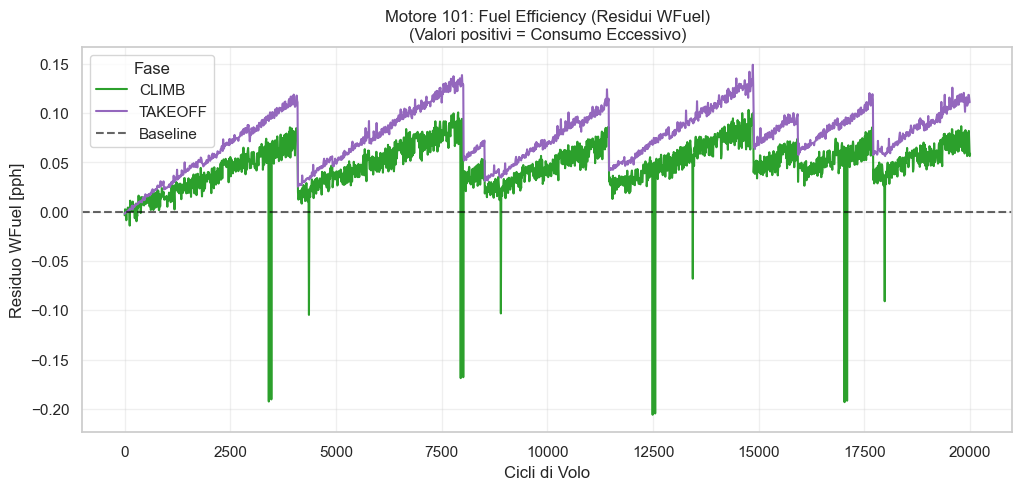

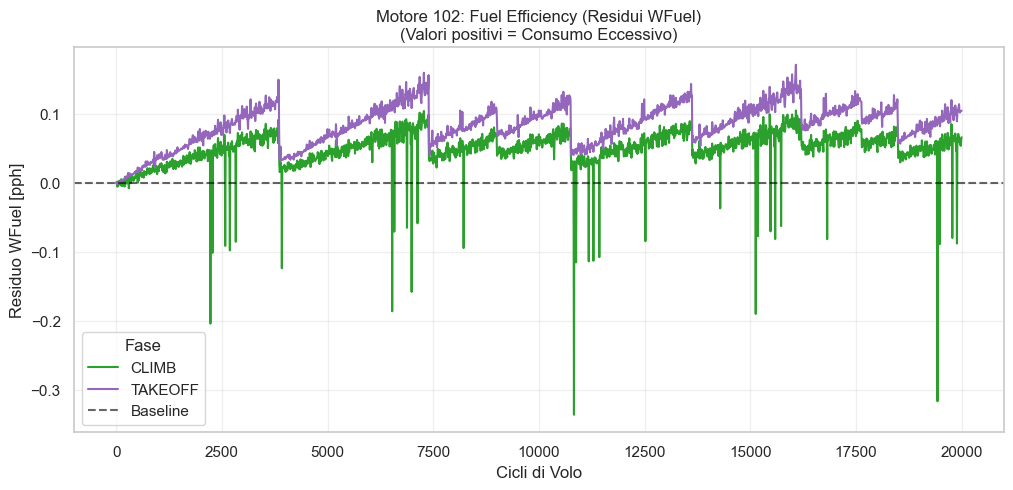

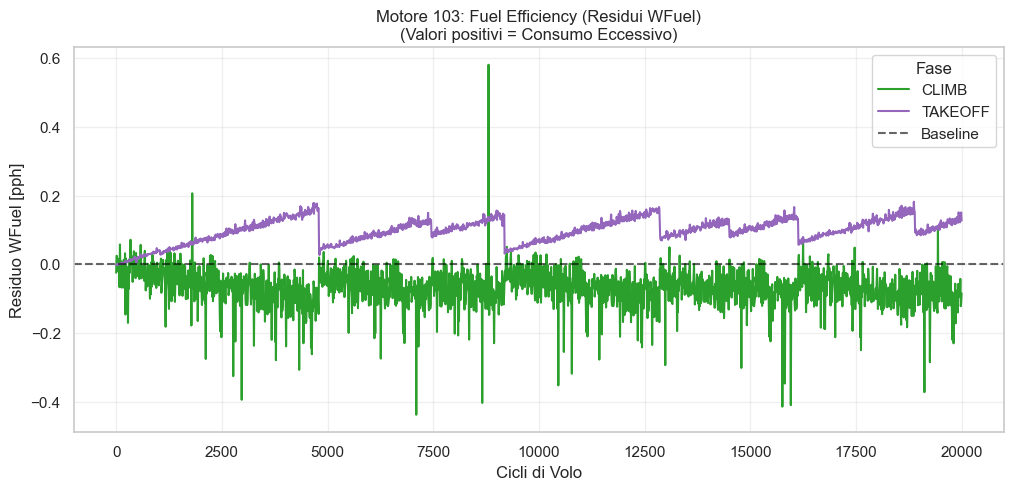

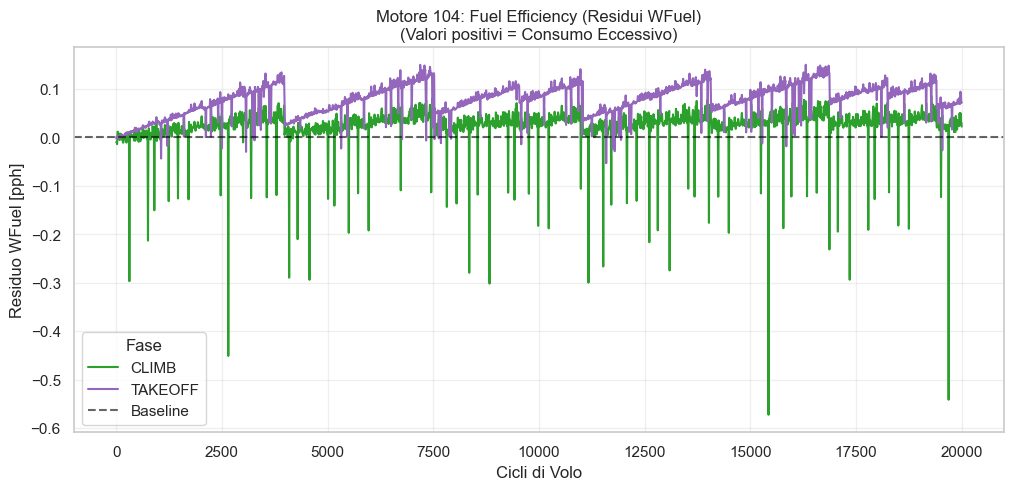

In [9]:
# --- CONFIGURAZIONE FUEL EFFICIENCY ---
fuel_features = ['Sensed_Ps3', 'Sensed_Core_Speed', 'Sensed_P25']
fuel_target = 'Sensed_WFuel'
fuel_phases = ['CLIMB', 'TAKEOFF']

# Esecuzione
df_res_fuel = calculate_residuals(
    df_input=df_segmented,
    features=fuel_features,
    target=fuel_target,
    phases_list=fuel_phases,
    resid_col_name='Fuel_Resid'
)

# --- VISUALIZZAZIONE FUEL EFFICIENCY ---
if not df_res_fuel.empty:
    unique_engines = df_res_fuel['ESN'].unique()[:4]

    print(f"Generazione grafici Fuel per i motori: {unique_engines}")

    for esn in unique_engines:
        subset = df_res_fuel[df_res_fuel['ESN'] == esn]

        plt.figure(figsize=(12, 5))

        sns.lineplot(
            data=subset,
            x='Cycles_Since_New',
            y='Fuel_Resid',
            hue='Phase',
            palette={'CLIMB': 'tab:green', 'TAKEOFF': 'tab:purple'},
        )

        plt.axhline(0, color='black', linestyle='--', alpha=0.6, label='Baseline')

        plt.title(f"Motore {esn}: Fuel Efficiency (Residui WFuel)\n(Valori positivi = Consumo Eccessivo)")
        plt.ylabel("Residuo WFuel [pph]") # Pounds per hour
        plt.xlabel("Cicli di Volo")
        plt.legend(title='Fase')
        plt.grid(True, alpha=0.3)
        plt.show()

else:
    print("Nessun dato Fuel disponibile per la visualizzazione.")

Questa analisi chiude il cerchio diagnostico e fornisce una "validazione incrociata" fondamentale.

**Conferma del Degrado**

In tutti i grafici il trend è **positivo crescente**, confermando l'ipotesi. Le linee partono da 0 (baseline) e salgono verso +0.10/+0.15 pph (pounds per hour di residuo). Quindi, si conferma i risultati che si erano ottenuti nella precedente analisi del carburante: per generare la stessa spinta (pressione e velocità), il motore sta bruciando sempre più carburante. Questo è l'effetto combinato di compressore sporco + turbina erosa.

**Analisi comparativa: TAKEOFF vs CLIMB**

In tutti i motori la linea viola (TAKEOFF) è **sistematicamente più alta** della linea verde (CLIMB). Si conferma l'ipotesi dello Stress Test: sotto carico massimo **le inefficienze si amplificano**. Inoltre, la linea verde è spesso più spessa (più rumorosa) della viola. Questo ribadisce che **il TAKEOFF è la fase più pulita e sensibile** per rilevare il degrado puro, mentre la CLIMB risente delle variazioni atmosferiche.

**Picchi negativi**

Anche qui si possono notare dei picchi verticali verdi verso il basso, che poi tornano su immediatamente: sono i momenti in cui il motore è stato lavato o è tornato in manutenzione.

**Anomalia Motore 103**

A differenza degli altri motori che hanno trend crescenti sia per TAKEOFF che per CLIMB, in questo motore il residuo in fase di CLIMB è **negativo e decresce**. Matematicamente, se il residuo è negativo significa che **il motore sta consumando meno carburante** di quanto il modello preveda per quelle condizioni di pressione e velocità.

La causa più probabile di questo fenomeno sul Motore 103 è un **cambiamento nello stile di conduzione del volo** (o una calibrazione diversa) specifico per la fase di Salita (CLIMB) rispetto ai primi 20 cicli di baseline.
- Se nei primi 20 cicli (baseline) l'aereo facesse tante salite molto aggressive il modello impara che dovrà consumare più carburante.
- Nei voli successivi, il pilota potrebbe aver adottato un profilo di salita più dolce o a quote più basse.
- Il modello vede le condizioni (Pressione/Velocità) e, basandosi sui ricordi aggressivi, predice un consumo alto, mentre il consumo reale è basso.

La fase di TAKEOFF, però, conferma la realtà, poiché in questa fase **non esistono stili di guida**. Quindi questo comportamento in TAKEOFF è un **falso segnale** (artefatto) dovuto ad un bias operativo. Di seguito un grafico che mostra se le ipotesi sono confermate o meno.

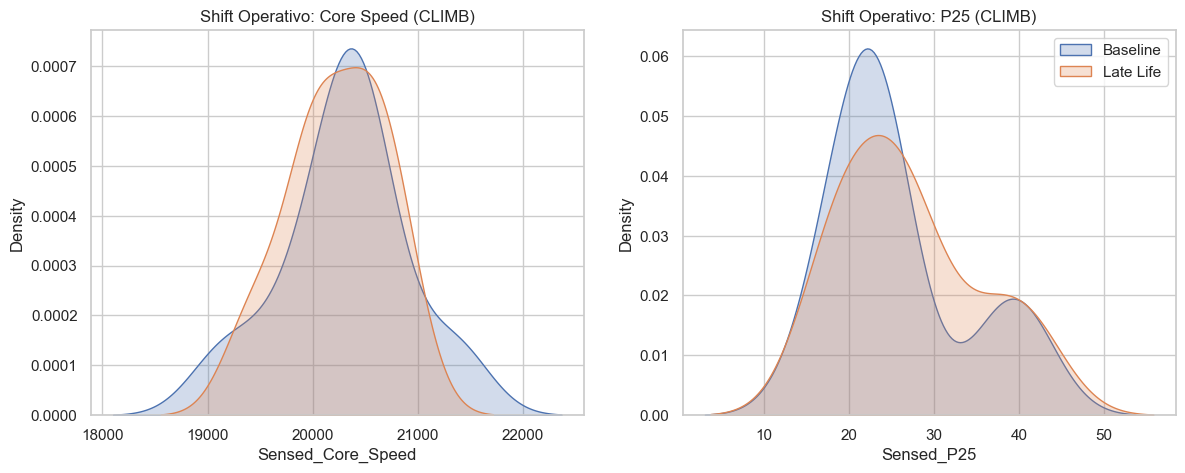

In [10]:
def check_operational_drift(df, esn, phase):
    subset = df[(df['ESN'] == esn) & (df['Flight_Phase'] == phase)]
    
    # Periodo A: Baseline (dove il modello ha imparato)
    period_A = subset[subset['Cycles_Since_New'] <= 50]
    
    # Periodo B: Vita Avanzata (dove il residuo è negativo)
    period_B = subset[(subset['Cycles_Since_New'] > 4000) & (subset['Cycles_Since_New'] <= 4050)]
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Confronto Velocità (Sforzo)
    sns.kdeplot(period_A['Sensed_Core_Speed'], label='Baseline (Cicli 0-50)', fill=True, ax=ax[0])
    sns.kdeplot(period_B['Sensed_Core_Speed'], label='Late Life (Cicli 4000+)', fill=True, ax=ax[0])
    ax[0].set_title(f"Shift Operativo: Core Speed ({phase})")
    
    # 2. Confronto Pressione (Quota/Carico)
    sns.kdeplot(period_A['Sensed_P25'], label='Baseline', fill=True, ax=ax[1])
    sns.kdeplot(period_B['Sensed_P25'], label='Late Life', fill=True, ax=ax[1])
    ax[1].set_title(f"Shift Operativo: P25 ({phase})")
    
    plt.legend()
    plt.show()

# Esecuzione per il motore 103 in CLIMB
check_operational_drift(df_segmented, esn=103, phase='CLIMB')

I grafici mostrano la conferma matematica e visiva che il Motore 103 ha subito uno **Shift operativo (Derating)** nella fase di CLIMB, condotta in modo più gentile.

- **Shift operativo Core Speed**: la campana della curva blu (primi 100 cicli) è centrata tra i valori 20.500 e 21.500 RPM, mentre la curva arancione (late life) si è spostata a sinistra. Il motore sta girando mediamente 500-1000 giri più lento durante la salita rispetto a quando era nuovo. Questo è un segno di **Reduced Thrust Climb** (salita a spinta ridotta) per risparmiare carburante e vita motore.
- **Shift operativo P25**: la curva blu presenta due gobbe con una densità sopra i 35-40 psi, mentre la gobba della curva arancione si è appiattita drasticamente. La maggior parte del tempo viene spesa a pressioni più basse (20-30 psia). 

Quindi, si può confermare che l'aereo **sta effettuando la fase di salita in condizioni di carico aerodinamico inferiore** (probabilmente iniziando la crociera prima o salendo più lentamente a quote dove la pressione è minore).

Per questo motivo verrà **creata una Feature di Contesto** `Operational_Profile` (0 = Standard, 1 = Drift/Aggressivo) che verrà impostata per il Motore 103 uguale a 1. Questa feature dirà al modello che il motore è posto sotto ad uno stress diverso.

#### **Differenza tra gli indicatori**

Creando questi quattro **sensori virtuali** si può quindi capire dove si dovrebbero utilizzare:

- **HPC Resid (Takeoff)**: è lo **specialista del compressore**. Vede solo se manca aria/pressione ed è sensibile ai Water-Wash.

- **HPT Resid (Climb)** è lo **specialista della turbina**. Vede solo se la turbina surriscalda quando il motore è sotto sforzo termico elevato e continuativo.

- **Global Resid (Cruise)**: è il **medico di base**. T45 aumenta sia se il compressore è sporco sia se la turbina è rotta, sommando **tutti i degradi**.

- **Fuel Efficiency Resid (Takeoff)**: è il **validatore economico**, misurando il **costo energetico** netto del degrado. Indipendentemente da cosa sia rotto (compressore o turbina), il sistema di controllo (FADEC) deve iniettare più carburante per mantenere le prestazioni. Se questo residuo sale, conferma che l'inefficienza è reale e non un errore dei sensori, impattando direttamente sui costi operativi.

---

### **Data Integration & Cleaning**

Dopo aver calcolato i Sensori Virtuali, si possono integrare tutti i dati in un unico dataframe che poi verrà utilizzato per **l'analisi della PCA**. Inoltre, come avendo già visto nei grafici, le linee dei residui sono ancora rumorose, a causa di piccole variazioni ciclo-ciclo. Quindi, si procederà applicando una **Media Mobile (Rolling Mean)** per trasformare le linee rumorose in curve più morbide e leggibili.

Come risultato finale verranno aggiunte altre colonne al dataset, che **aiuteranno il modello alla ricerca dei target**, poiché utilizzando tutti i dati l'algoritmo scambierebbe ogni piccolo picco di rumore per un evento di manutenzione.

In [ ]:
data_segmented = df_segmented.copy()
print(f"Dimensioni Iniziali (Snapshot): {data_segmented.shape}")

# Definizione la mappa dei residui
residuals_map = {
    'HPC_Resid': df_res_hpc if 'df_res_hpc' in locals() else None,
    'HPT_Resid': df_res_hpt if 'df_res_hpt' in locals() else None,
    'Global_Resid': df_res_global if 'df_res_global' in locals() else None,
    'Fuel_Resid': df_res_fuel if 'df_res_fuel' in locals() else None
}

# Ciclo di Merge con Protezione Duplicati
for res_name, df_res in residuals_map.items():
    if df_res is not None and not df_res.empty:
        cols_to_use = ['ESN', 'Cycles_Since_New', res_name]

        # Prende solo una riga per ciclo. Se ce ne sono due uguali, se ne terrà una.
        df_res_clean = df_res[cols_to_use].drop_duplicates(subset=['ESN', 'Cycles_Since_New'])

        # Merge
        data_segmented = data_segmented.merge(
            df_res_clean,
            on=['ESN', 'Cycles_Since_New'],
            how='left'
        )

        # Riempe i NaN con 0
        data_segmented[res_name] = data_segmented[res_name].fillna(0)  
        print(f"  -> Aggiunto {res_name}")

cols_to_drop = ['Cycle_Phase', 'Alt_Delta', 'Alt_Delta_Next', 'Flight_Progress', 'Alt_Ground', 'Ground_Threshold']
data_segmented = data_segmented.drop(columns=[c for c in cols_to_drop if c in data_segmented.columns])

print(f"\nDimensioni Finali: {data_segmented.shape}")

print("\nPRIME 5 RIGHE DEL DATASET COMPLETO")
pd.set_option('display.max_columns', None)
print(data_segmented.head(5))

Dimensioni Iniziali (Snapshot): (51396, 33)
  -> Aggiunto HPC_Resid
  -> Aggiunto HPT_Resid
  -> Aggiunto Global_Resid
  -> Aggiunto Fuel_Resid

Dimensioni Finali: (51396, 31)

PRIME 5 RIGHE DEL DATASET COMPLETO
   ESN  Cycles_Since_New  Snapshot  Cumulative_WWs  Cumulative_HPC_SVs  \
0  101                 0         2               0                   0   
1  101                 0         3               0                   0   
2  101                 0         4               0                   0   
3  101                 0         6               0                   0   
4  101                 0         7               0                   0   

   Cumulative_HPT_SVs  Sensed_Altitude  Sensed_Mach  Sensed_Pamb  Sensed_Pt2  \
0                   0       903.321516     0.213663    14.224853   14.628042   
1                   0      3410.321516     0.345333    12.989563   14.055733   
2                   0     20259.321516     0.619005     6.679796    8.621275   
3                   0  

In [12]:
# Identificazione colonne
cols_to_smooth = ['HPC_Resid', 'HPT_Resid', 'Global_Resid', 'Fuel_Resid']
cols_present = [c for c in cols_to_smooth if c in data_segmented.columns]

# Parametro Smoothing
WINDOW = 10

# 2. Creazione dataframe per ciclo
df_cycle_unique = data_segmented.groupby(['ESN', 'Cycles_Since_New'])[cols_present].first().reset_index()

frames_smooth = []

# Calcolo Rolling Mean
for esn, group in df_cycle_unique.groupby('ESN'):
    group = group.sort_values('Cycles_Since_New').copy()

    for col in cols_present:
        new_col_name = f"{col}_Smooth"
        # Rolling mean centrata
        group[new_col_name] = group[col].rolling(window=WINDOW, center=True).mean()
        # Fill bordi
        group[new_col_name] = group[new_col_name].fillna(group[col])

    frames_smooth.append(group)

df_smoothed_cycles = pd.concat(frames_smooth)

# Seleziona solo le chiavi e le nuove colonne _Smooth
cols_smooth_names = [f"{c}_Smooth" for c in cols_present]
df_to_merge = df_smoothed_cycles[['ESN', 'Cycles_Since_New'] + cols_smooth_names]

# Merge finale
data_segmented = data_segmented.merge(df_to_merge, on=['ESN', 'Cycles_Since_New'], how='left')
print("Colonne aggiunte:", cols_smooth_names)

# Aggiunta colonna 'Operational_Profile' (Motore 103 = 1, gli altri 0)
data_segmented['Operational_Profile'] = 0
data_segmented.loc[data_segmented['ESN'] == 103, 'Operational_Profile'] = 1
print("\nColonna 'Operational_Profile' aggiunta al dataset.")

Colonne aggiunte: ['HPC_Resid_Smooth', 'HPT_Resid_Smooth', 'Global_Resid_Smooth', 'Fuel_Resid_Smooth']

Colonna 'Operational_Profile' aggiunta al dataset.


In [13]:
# Salvataggio del dataset con i residui
output_filename = '../data/temp/02_training_data_residuals.csv'
data_segmented.to_csv(output_filename, index=False)
print(f"\nDataset pulito salvato in: {output_filename}")


Dataset pulito salvato in: ../data/temp/02_training_data_residuals.csv
